<a href="https://colab.research.google.com/github/Nesrin48/HandGestureRecognition/blob/master/HandGestureRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ici, nous importons tout ce dont nous avons besoin pour le projet
# Il est toujours recommandé de les mettre dans la première cellule
from os import listdir
from os import path

#TensorFlow et tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder # pour un encodage à chaud
from keras.models import load_model # pour charger le modèle enregistré 
import json # charger le fichier json
from PIL import Image # Manipulations d'images
%matplotlib inline

# Pour ouvrir le lecteur
from google.colab import drive


# Importation de modèle de kéros et de couches cachées pour notre réseau convolutionnel
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

# Sklearn
from sklearn.model_selection import train_test_split # Aide à organiser les données pour la formation
from sklearn.metrics import confusion_matrix # Aide à présenter les résultats sous forme de matrice de confusion

print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!git clone https://github.com/Nesrin48/HandGestureRecognition.git

Cloning into 'HandGestureRecognition'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 2536 (delta 4), reused 0 (delta 0), pack-reused 2527
Receiving objects: 100% (2536/2536), 254.38 MiB | 39.99 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
# drive.mount('/content/gdrive')

In [5]:
# !ls "/content/gdrive/My Drive/HandGesture"
# to be done first time only to unzip the file
# !unzip "/content/gdrive/My Drive/HandGesture/hand_gesture.zip" -d "/content/gdrive/My Drive/HandGesture/hand_gesture"

In [6]:
## Set all the parameter of the model here 
# image_dir = '/content/gdrive/My Drive/HandGesture/hand_gesture/hand_gesture/'
image_dir = 'HandGestureRecognition/handgesture_dataset/'
num_classes = 36

In [7]:
#Cette fonction est davantage utilisée pour le débogage et pour afficher les résultats ultérieurement. Il trace l'image dans le cahier
def imshow(image_path):
  # Ouvrez l'image pour l'afficher dans la première colonne de l'intrigue
  image = Image.open(image_path)  
  # Créer la figure
  fig = plt.figure(figsize=(50,5))
  ax = fig.add_subplot(1, 1, 1) 
  # Tracer l'image dans la première hache avec son nom de catégorie
  ax.axis('off')
  ax.set_title(image_path)
  ax.imshow(image)

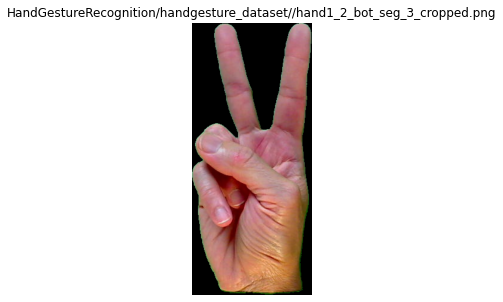

In [8]:
imshow(image_dir + "/hand1_2_bot_seg_3_cropped.png")

In [9]:
def get_hand_gesture_labels(image_dir):
    """
    Creates a dictionary of image labels (results_dic) based upon the filenames 
    of the image files. These image image labels are used to check the accuracy 
    of the labels that are returned by the classifier function, since the 
    filenames of the images contain the true identity of the image in the image.
    Be sure to format the image labels so that they are in all lower case letters
    and with leading and trailing whitespace characters stripped from them.
    (ex. filename = 'hand1_z_dif_seg_4_cropped.png' image label = 'z')
    Parameters:
     image_dir - The (full) path to the folder of images that are to be
                 classified by the classifier function (string)
    Returns:
      results_dic - Dictionary with 'key' as image filename and 'value' as a 
      List. The list contains for following item:
         index 0 = image image label (string)
    """

    # Retrieve the filenames from folder hand_gesture_images/
    in_files = listdir(image_dir)
    # Creates empty dictionary for the results (image labels, etc.)
    results_dic = dict()
    # Processes through each file in the directory, extracting only the words
    # of the file that contain the image image label
    for idx in range(0, len(in_files), 1):
        # Skips file if starts with . (like .DS_Store of Mac OSX) because it 
        # isn't an hand gesture image file
        if in_files[idx][0] != ".":
            if in_files[idx] not in results_dic:
                # Creates temporary label variable to hold pet label name extracted 
                hand_gesture_label = ""         
                # Sets hand_gesture_image variable to a filename after removing the file extension => we can escape this step :D.
                hand_gesture_image = path.splitext(in_files[idx])[0]
                # Sets string to lower case letters
                low_hand_gesture_image = hand_gesture_image.lower()
                # Split the file name by "_" splitter             
                word_list_hand_gesture_image = low_hand_gesture_image.split("_")
                # get hand gesture element which is in the position 2 in the file name 
                hand_gesture_name = word_list_hand_gesture_image[1]
  
                # Strip off starting/trailing whitespace characters 
                hand_gesture_label = hand_gesture_name.strip()
                
                # Add hand_gesture_label as value of the file name key
                results_dic[in_files[idx]] = hand_gesture_label
            else:
                print("** Warning: Duplicate files exist in directory:",in_files[idx])
                
    return results_dic

In [10]:
results_dic = get_hand_gesture_labels(image_dir)
results_dic

{'hand2_f_right_seg_2_cropped.png': 'f',
 'hand2_z_bot_seg_5_cropped.png': 'z',
 'hand2_b_bot_seg_4_cropped.png': 'b',
 'hand1_w_bot_seg_1_cropped.png': 'w',
 'hand2_j_dif_seg_4_cropped.png': 'j',
 'hand5_v_bot_seg_1_cropped.png': 'v',
 'hand2_p_top_seg_1_cropped.png': 'p',
 'hand5_q_bot_seg_1_cropped.png': 'q',
 'hand2_9_top_seg_4_cropped.png': '9',
 'hand2_v_bot_seg_1_cropped.png': 'v',
 'hand1_5_bot_seg_3_cropped.png': '5',
 'hand2_o_bot_seg_1_cropped.png': 'o',
 'hand2_e_dif_seg_1_cropped.png': 'e',
 'hand1_i_bot_seg_5_cropped.png': 'i',
 'hand3_y_dif_seg_2_cropped.png': 'y',
 'hand2_2_right_seg_1_cropped.png': '2',
 'hand5_6_dif_seg_4_cropped.png': '6',
 'hand3_u_dif_seg_1_cropped.png': 'u',
 'hand1_t_bot_seg_5_cropped.png': 't',
 'hand1_r_right_seg_4_cropped.png': 'r',
 'hand2_s_top_seg_2_cropped.png': 's',
 'hand5_a_dif_seg_4_cropped.png': 'a',
 'hand1_v_right_seg_1_cropped.png': 'v',
 'hand1_z_left_seg_4_cropped.png': 'z',
 'hand2_q_left_seg_5_cropped.png': 'q',
 'hand1_u_bot_s

In [11]:
def dataset(image_dir):
  X = [] # Image data
  Y = [] # Labels

  #Boucles à travers des chemins d'image pour charger des images et des étiquettes dans des tableaux
  for key in results_dic:
    img = cv2.imread(image_dir + '/'+ key) # Lit l'image et retourne np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convertit dans l'espace colorimétrique corret (GRIS)
    img = cv2.resize(img, (320, 120)) # Réduisez la taille de l'image pour accélérer la formation
    X.append(img)
    
    #Obtenez l'étiquette
    label = results_dic[key]
    # Ajouter les étiquettes
    Y.append(label)

  # Transformez X et y en np.array pour accélérer train_test_split
  X = np.array(X, dtype="uint8")
  Y = np.array(Y)
  print("len(image_dir)",len(image_dir))
  print("len(image_dir)",len(results_dic))
  print("Shape of X ", X.shape)
  print("Shape of Y ", Y.shape)
  X = X.reshape(len(results_dic), 120, 320, 1) # Besoin de remodeler pour que CNN sache que ce sont des images différentes
  print("Shape of X after reshaping ", X.shape)
  return X,Y

In [12]:
X,Y = dataset(image_dir)
print("Images loaded: ", len(X))
print("Labels loaded: ", len(Y))

len(image_dir) 43
len(image_dir) 2515
Shape of X  (2515, 120, 320)
Shape of Y  (2515,)
Shape of X after reshaping  (2515, 120, 320, 1)
Images loaded:  2515
Labels loaded:  2515


In [13]:
ts = 0.3 # Pourcentage d'images que nous voulons utiliser pour les tests. Le reste est utilisé pour la formation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ts, random_state=42)
y_train.size

1760

In [14]:
def one_hot_encode(data):
  label_encoder = LabelEncoder()
  vec = label_encoder.fit_transform(data)
  return vec

In [15]:
print("y_train[:5]", y_train[:5])
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)
print("y_train[:5]", y_train[:5])

y_train[:5] ['6' 'q' 'o' 'a' 'r']
y_train[:5] [ 6 26 24 10 27]


In [16]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

In [17]:
# Configure le modèle de formation
model.compile(optimizer='adam', # Routine d'optimisation, qui indique à l'ordinateur comment ajuster les valeurs des paramètres pour minimiser la fonction de perte.
              loss='sparse_categorical_crossentropy', #Fonction de perte, qui nous indique à quel point nos prévisions sont mauvaises.
              metrics=['accuracy']) # Liste des métriques à évaluer par le modèle lors de la formation et des tests.

In [18]:
# Forme le modèle pour un nombre donné d'époques (itérations sur un jeu de données) et le valide
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 1760 samples, validate on 755 samples
Epoch 1/5
 - 8s - loss: 14.5255 - accuracy: 0.4062 - val_loss: 0.7001 - val_accuracy: 0.7815
Epoch 2/5
 - 1s - loss: 0.3133 - accuracy: 0.9017 - val_loss: 0.3687 - val_accuracy: 0.8901
Epoch 3/5
 - 1s - loss: 0.0875 - accuracy: 0.9733 - val_loss: 0.2733 - val_accuracy: 0.9325
Epoch 4/5
 - 1s - loss: 0.0382 - accuracy: 0.9909 - val_loss: 0.3114 - val_accuracy: 0.9245
Epoch 5/5
 - 1s - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.3022 - val_accuracy: 0.9377


In [19]:
# Enregistrer le modèle entier dans un fichier HDF5
model.save('handrecognition_model.h5')

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

755/755 [==============================] - 0s 356us/step
Test accuracy: 93.77%


In [21]:
predictions = model.predict(X_test) # Faire des prédictions vers l'ensemble de test
np.argmax(predictions[0]), y_test[0] # Si c'est la même chose, bien compris

(23, 23)

In [22]:
model = load_model('handrecognition_model.h5')
y_pred = model.predict_classes(X_test)
import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_pred), np.array(y_test))
print(acc)

0.937748344370861


In [23]:
def cat_to_name(path):
    with open(path+'cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
        return cat_to_name

cat_to_name = cat_to_name("HandGestureRecognition/")

In [24]:
def process_image(image_path):
  X = [] # Image data
  img = cv2.imread(image_path) # Lit l'image et retourne np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convertit dans l'espace colorimétrique corret (GRIS)
  img = cv2.resize(img, (320, 120)) # Réduisez la taille de l'image pour accélérer la formation
  X.append(img)
  # Transformez X en np.array pour accélérer train_test_split
  X = np.array(X, dtype="uint8")
  print("Shape of X ", X.shape)
  X = X.reshape(len(X), 120, 320, 1) # Besoin de remodeler pour que CNN sache que ce sont des images différentes
  print("Shape of X after reshaping ", X.shape)
  return X

In [25]:
def predict(image_path, model, cat_to_name,topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    X = process_image(image_path)
    # Obtenez le prob topk en utilisant model.predict_proba qui retourne les meilleures probablilties
    # pour tous les calsses dans l'ordre descendant
    top_p = model.predict_proba(X[:1])[0]
    top_p = [top_p[i] for i in np.argsort(top_p)[-topk:]] # Ici, nous obtenons les probas topk mais dans l'ordre d'assentiment
    top_p = top_p[::-1] # inverser l'ordre pour obtenir la valeur la plus élevée à la plus petite de la liste des meilleures sondes
    # Obtenez les classes topk
    top_c = model.predict(X[:1]) 
    top_c = np.argsort(top_c)[:,-topk:][0]
    top_c = top_c[::-1] #elment inverse pour obtenir l'ordre descenedent

    # Extraire les noms de classes des index de classes
    top_classes = [
        cat_to_name[str(category)] for category in top_c
        ]
    return top_p, top_classes

In [26]:
def display_prediction(image_path,model,cat_to_name, topk=5):
    # Ouvrez l'image pour l'afficher dans la première colonne de l'intrigue
    image = Image.open(image_path)   
    #prédire les classes topk
    top_probs, top_classes = predict(image_path, model, cat_to_name,topk)   
    print("top_probs", top_probs)
    print("top_classes ", top_classes )
    #Obtenez la classe supérieure qui a le probat max
    top_p = top_probs[np.argmax(top_probs)] # the top class proba
    top_c = top_classes[np.argmax(top_probs)] # top class label    

    # Créer la figure
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)    
    #Tracer l'image dans la première hache avec son nom de catégorie
    ax1.axis('off')
    ax1.set_title(top_c)
    ax1.imshow(image) 
    #Créer le deuxième tracé
    #Définir les étiquettes des y-awes de la deuxième parcelle
    labels = []
    for classe in top_classes:
        labels.append(classe)
    y_pos = np.arange(topk)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()  # les probabilités se lisent de haut en bas
    ax2.barh(y_pos, top_probs, xerr=0, align='center')

    plt.show() # montrer l'intrigue

Shape of X  (1, 120, 320)
Shape of X after reshaping  (1, 120, 320, 1)
top_probs [0.99995375]
top_classes  ['2']


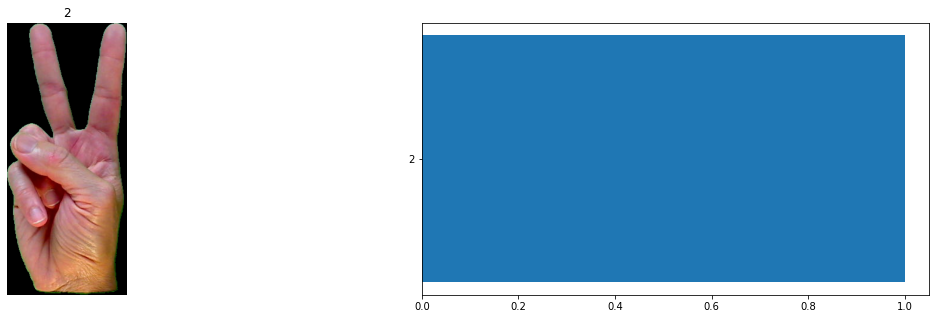

In [64]:
ex_image = image_dir + "/hand1_2_bot_seg_3_cropped.png"
display_prediction(ex_image,model,cat_to_name, topk=1)

In [28]:
arr = [5, 8, 2, 1, 0, 20 , 3]
top_arr = [arr[i] for i in np.argsort(arr)[-3:]]
print("top_arr", top_arr[::-1])

top_arr [20, 8, 5]


In [29]:
!git clone https://github.com/Nesrin48/HandGestureRecognition.git

fatal: destination path 'HandGestureRecognition' already exists and is not an empty directory.


In [30]:
!python HandGestureRecognition/train.py HandGestureRecognition/handgesture_dataset/ --save_dir checkpoints --epochs 5

Using TensorFlow backend.
2020-06-23 00:35:02.597810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

############### Train ####################

len(image_dir) 43
len(image_dir) 2515
Shape of X  (2515, 120, 320)
Shape of Y  (2515,)
Shape of X after reshaping  (2515, 120, 320, 1)
2020-06-23 00:35:11.820078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-23 00:35:11.822639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-23 00:35:11.823139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s

In [31]:
!python HandGestureRecognition/predict.py  HandGestureRecognition/handgesture_dataset/hand1_2_bot_seg_3_cropped.png checkpoints --category_names HandGestureRecognition/cat_to_name.json --top_k 5

Using TensorFlow backend.
2020-06-23 00:35:24.486928: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

############### Predict ####################

2020-06-23 00:35:26.323900: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-23 00:35:26.326291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-23 00:35:26.326764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-06-23 00:35:26.326810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libc